# Halo Mass Function Calculations with halox

This notebook demonstrates the halo mass function (HMF) calculations available in the `halox` library. We'll explore the Tinker et al. 2008 mass function formalism and its key properties.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from halox import cosmology, hmf

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

## Setting up the Cosmology

First, let's create a cosmology object using the Planck 2018 parameters provided by halox:

In [2]:
# Create a Planck 2018 cosmology
cosmo = cosmology.Planck18()
print(f"Hubble parameter h = {cosmo.h}")
print(f"Matter density Ω_m = {cosmo.Omega_m}")
print(f"Baryon density Ω_b = {cosmo.Omega_b}")
print(f"Cold dark matter density Ω_c = {cosmo.Omega_c}")
print(f"Power spectrum normalization σ_8 = {cosmo.sigma8}")

Hubble parameter h = 0.6766
Matter density Ω_m = 0.30964
Baryon density Ω_b = 0.04897
Cold dark matter density Ω_c = 0.26067
Power spectrum normalization σ_8 = 0.8102


## Halo Mass Function Theory

The halo mass function describes the number density of dark matter halos per unit mass. The Tinker et al. 2008 formalism expresses this as:

$$\frac{{\rm d}n}{{\rm d}\ln M} = f(\sigma) \frac{\bar{\rho}_m}{M} \left|\frac{{\rm d}\ln \sigma}{{\rm d}M}\right|$$

where:
- $\bar{\rho}_m$ is the mean matter density
- $\sigma(M)$ is the RMS variance of density fluctuations on the mass scale M
- $f(\sigma)$ is the multiplicity function given by:

$$f(\sigma) = A \left[\left(\frac{b}{\sigma}\right)^a + 1\right] \exp\left(-\frac{c}{\sigma^2}\right)$$

The parameters $A$, $a$, $b$, and $c$ depend on the overdensity threshold and redshift.

## Basic Mass Function Calculation

Let's compute the mass function for a range of halo masses at z=0:

In [3]:
# Mass range from 10^10 to 10^16 h^-1 M_sun
M = jnp.logspace(10, 16, 100)
z = 0.0
delta_c = 200.0

# Compute the mass function
dn_dlnM = hmf.tinker08_mass_function(M, z, cosmo, delta_c)

print(f"Mass function computed for {len(M)} mass bins")
print(f"Mass range: {M.min():.2e} to {M.max():.2e} h^-1 M_sun")
print(f"dn/dlnM range: {dn_dlnM.min():.2e} to {dn_dlnM.max():.2e} h^3 Mpc^-3")

Mass function computed for 100 mass bins
Mass range: 1.00e+10 to 1.00e+16 h^-1 M_sun
dn/dlnM range: 1.51e-14 to 2.40e-01 h^3 Mpc^-3


## Mass Function Visualization

Let's plot the mass function showing the characteristic shape:

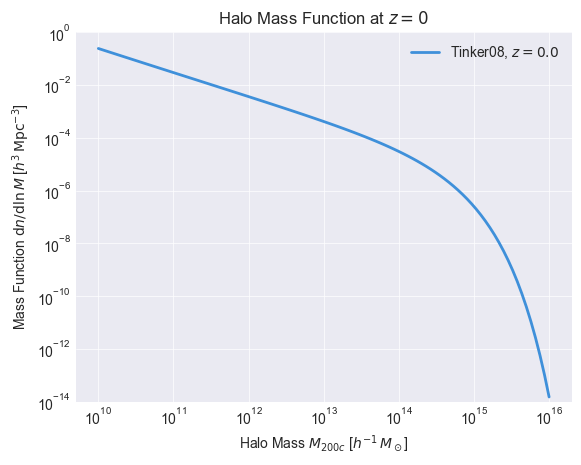

In [4]:
# Plot the mass function
fig, ax = plt.subplots()
ax.loglog(M, dn_dlnM, linewidth=2, color="C0", label=f"Tinker08, $z={z:.1f}$")
ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(
    r"Mass Function ${\rm d}n/{\rm d}\ln M$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax.set_title("Halo Mass Function at $z=0$")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(1e-14, 1e0)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different Cosmologies

Let's compare the mass function for different cosmological parameters. We'll vary the matter density and power spectrum normalization:

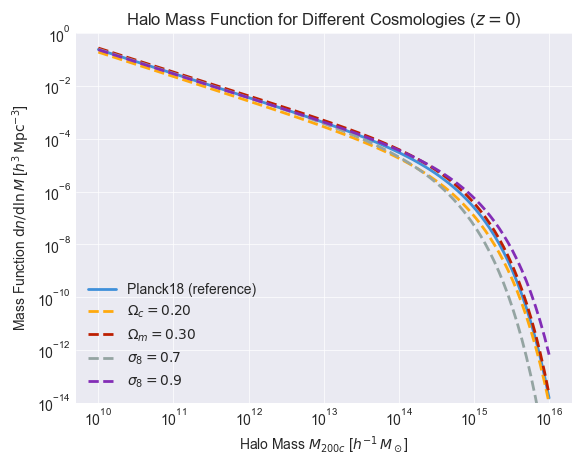

In [5]:
# Create different cosmologies by modifying Planck18 parameters
cosmo_low_Om = cosmology.Planck18(Omega_c=0.20)
cosmo_high_Om = cosmology.Planck18(Omega_c=0.30)
cosmo_low_s8 = cosmology.Planck18(sigma8=0.7)
cosmo_high_s8 = cosmology.Planck18(sigma8=0.9)

cosmologies = [cosmo_low_Om, cosmo_high_Om, cosmo_low_s8, cosmo_high_s8]
labels = [
    r"$\Omega_c = 0.20$",
    r"$\Omega_m = 0.30$",
    r"$\sigma_8 = 0.7$",
    r"$\sigma_8 = 0.9$",
]
colors = ["C1", "C2", "C3", "C4"]

fig, ax = plt.subplots()

# Plot reference Planck18 cosmology
dn_dlnM_ref = hmf.tinker08_mass_function(M, z, cosmo, delta_c)
ax.loglog(
    M,
    dn_dlnM_ref,
    linewidth=2,
    color="C0",
    label="Planck18 (reference)",
    linestyle="-",
)

# Plot different cosmologies
for i, (cosmo_test, label, color) in enumerate(
    zip(cosmologies, labels, colors)
):
    dn_dlnM_test = hmf.tinker08_mass_function(M, z, cosmo_test, delta_c)
    ax.loglog(
        M, dn_dlnM_test, linewidth=2, color=color, label=label, linestyle="--"
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(
    r"Mass Function ${\rm d}n/{\rm d}\ln M$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax.set_title("Halo Mass Function for Different Cosmologies ($z=0$)")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(1e-14, 1e0)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Redshift Evolution

Now let's examine how the mass function evolves with redshift:

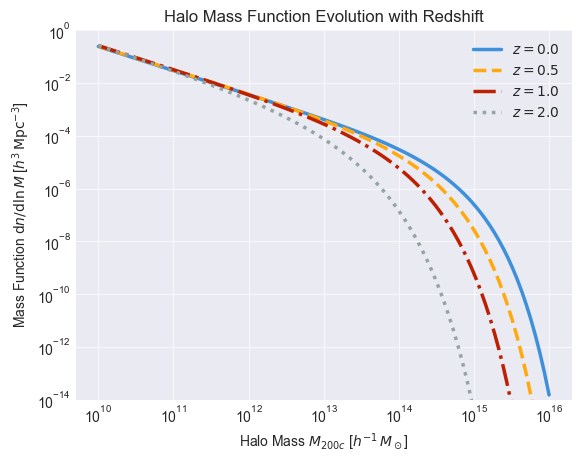

In [6]:
# Different redshifts
redshifts = [0.0, 0.5, 1.0, 2.0]
colors = ["C0", "C1", "C2", "C3"]
linestyles = ["-", "--", "-.", ":"]

fig, ax = plt.subplots()

for z_val, color, ls in zip(redshifts, colors, linestyles):
    dn_dlnM_z = hmf.tinker08_mass_function(M, z_val, cosmo, delta_c)
    ax.loglog(
        M,
        dn_dlnM_z,
        linewidth=2.5,
        color=color,
        linestyle=ls,
        label=f"$z = {z_val:.1f}$",
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(
    r"Mass Function ${\rm d}n/{\rm d}\ln M$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax.set_title("Halo Mass Function Evolution with Redshift")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(1e-14, 1e0)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different Overdensity Definitions

The Tinker08 formalism supports different overdensity definitions. Let's compare Δ = 200c and Δ = 500c:

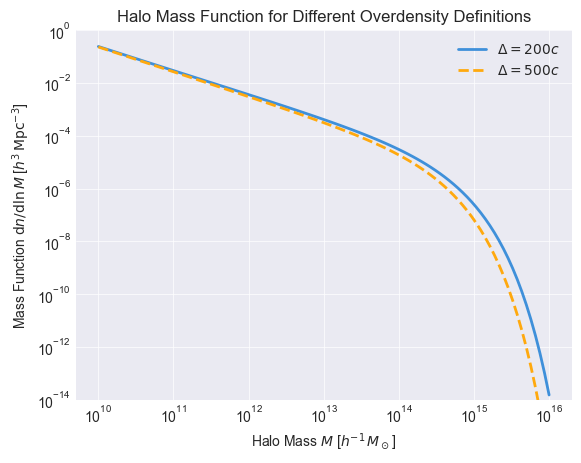

In [7]:
# Different overdensity thresholds
deltas = [200.0, 500.0]
colors = ["C0", "C1"]
linestyles = ["-", "--"]

fig, ax = plt.subplots()

z = 0.0
for delta, color, ls in zip(deltas, colors, linestyles):
    dn_dlnM_delta = hmf.tinker08_mass_function(M, z, cosmo, delta)
    ax.loglog(
        M,
        dn_dlnM_delta,
        linewidth=2,
        color=color,
        linestyle=ls,
        label=f"$\\Delta = {delta:.0f}c$",
    )

ax.set_xlabel(r"Halo Mass $M$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(
    r"Mass Function ${\rm d}n/{\rm d}\ln M$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax.set_title("Halo Mass Function for Different Overdensity Definitions")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(1e-14, 1e0)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Vectorization

The HMF functions support vectorized operations, allowing efficient computation for multiple masses and redshifts:

Computed HMF for 50 masses and 5 redshifts
Result shape: (5, 50)


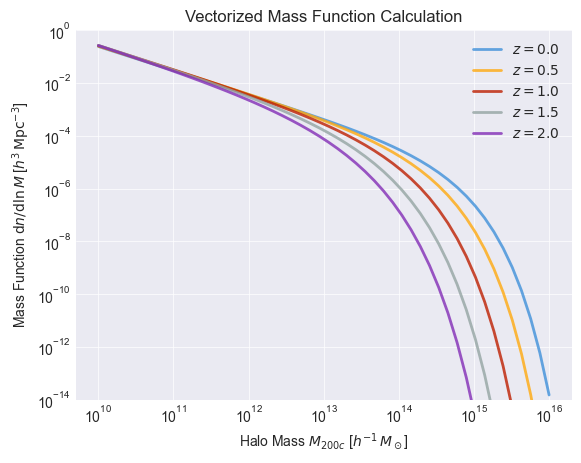

In [8]:
# Vectorized computation for multiple redshifts
M_vec = jnp.logspace(10, 16, 50)  # Smaller mass range for clarity
z_vec = jnp.array([0.0, 0.5, 1.0, 1.5, 2.0])

# Use vmap to vectorize over redshift
dn_dlnM_vec = jax.vmap(
    hmf.tinker08_mass_function, in_axes=[None, 0, None, None]
)(M_vec, z_vec, cosmo, delta_c)

print(f"Computed HMF for {len(M_vec)} masses and {len(z_vec)} redshifts")
print(f"Result shape: {dn_dlnM_vec.shape}")

# Plot the results
fig, ax = plt.subplots()

for i, z_val in enumerate(z_vec):
    ax.loglog(
        M_vec,
        dn_dlnM_vec[i],
        linewidth=2,
        label=f"$z = {z_val:.1f}$",
        alpha=0.8,
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(
    r"Mass Function ${\rm d}n/{\rm d}\ln M$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax.set_title("Vectorized Mass Function Calculation")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(1e-14, 1e0)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Lightcone Halo Abundance

For surveys and lightcone simulations, we often want to know the expected number of halos as a function of both mass and redshift. This is given by:

$$\frac{{\rm d}n}{{\rm d}\ln M \, dz} = \frac{{\rm d}n}{{\rm d}\ln M} \times \frac{{\rm d}V_c}{{\rm d}\Omega \, {\rm d}z} \times \Omega$$

where ${\rm d}V_c/{\rm d}\Omega \, {\rm d}z$ is the differential comoving volume element per solid angle and redshift, and $\Omega$ is the solid angle of the survey (we'll use $\Omega = 4\pi$ for the full sky).

In [9]:
# Create mass and redshift grids
M_grid = jnp.logspace(12, 16, 32)  # Mass range from 10^12 to 10^16 h^-1 M_sun
z_grid = jnp.linspace(0.01, 2.01, 64)  # Redshift range from 0 to 2

# Create 2D grids for vectorized computation
Z_grid, M_grid_2d = jnp.meshgrid(z_grid, M_grid, indexing="ij")

print(
    f"Mass grid: {len(M_grid)} points from {M_grid.min():.2e} to {M_grid.max():.2e} h^-1 M_sun"
)
print(
    f"Redshift grid: {len(z_grid)} points from {z_grid.min():.1f} to {z_grid.max():.1f}"
)
print(f"2D grid shape: {Z_grid.shape}")

Mass grid: 32 points from 1.00e+12 to 1.00e+16 h^-1 M_sun
Redshift grid: 64 points from 0.0 to 2.0
2D grid shape: (64, 32)


In [10]:
# Compute the mass function at each (z, M) point
# We need to vectorize over both redshift and mass simultaneously
def compute_dn_dlnM_dz(z, m):
    # Mass function dn/dlnM [h^3 Mpc^-3]
    dn_dlnM = hmf.tinker08_mass_function(m, z, cosmo, delta_c=200.0)

    # Differential comoving volume element [h^-3 Mpc^3 sr^-1]
    dV_dOmega_dz = cosmology.differential_comoving_volume(z, cosmo)

    # Full sky solid angle
    solid_angle = 4 * jnp.pi  # steradians

    # Lightcone abundance: dn/dlnM/dz [h^0 = dimensionless]
    return dn_dlnM * dV_dOmega_dz * solid_angle


# Vectorize the computation over the 2D grid
compute_dn_dlnM_dz_vmap = jax.vmap(
    jax.vmap(compute_dn_dlnM_dz, in_axes=(None, 0)), in_axes=(0, None)
)
dn_dlnM_dz = jnp.squeeze(compute_dn_dlnM_dz_vmap(z_grid, M_grid))

print(f"Lightcone abundance computed with shape: {dn_dlnM_dz.shape}")
print(f"Range: {dn_dlnM_dz.min():.2e} to {dn_dlnM_dz.max():.2e}")

Lightcone abundance computed with shape: (64, 32)
Range: 3.54e-36 to 4.41e+08


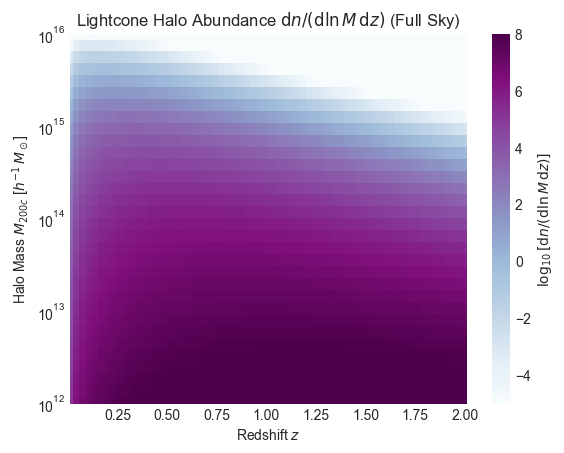

In [21]:
# Create the 2D plot
fig, ax = plt.subplots()

# Use pcolormesh for the 2D color plot with log scale
# Note: we need to use log10 of the data for proper log scaling
im = ax.pcolormesh(
    z_grid,
    M_grid,
    jnp.log10(dn_dlnM_dz.T),
    cmap="BuPu",
    shading="auto",
    vmin=-5,
    vmax=8,
)

# Set labels and title
ax.set_xlabel("Redshift $z$")
ax.set_ylabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_title(
    r"Lightcone Halo Abundance ${\rm d}n/({\rm d}\ln M \, {\rm d}z)$ (Full Sky)"
)

# Set axes to log scale
ax.set_yscale("log")
ax.set_xlim(z_grid.min(), z_grid.max())
ax.set_ylim(M_grid.min(), M_grid.max())

# Add colorbar
cbar = plt.colorbar(
    im, ax=ax, label=r"$\log_{10}[{\rm d}n/({\rm d}\ln M \, {\rm d}z)]$"
)

# Set axis ticks
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

## Performance: JIT Compilation

Let's compare the performance with and without JIT compilation:

In [12]:
# Setup for timing
M_timing = jnp.logspace(10, 16, 100)
z_timing = 0.0


def compute_hmf(M, z, cosmo=cosmo, delta_c=200.0):
    return hmf.tinker08_mass_function(M, z, cosmo, delta_c)

Without JIT compilation:

In [13]:
%timeit _ = compute_hmf(M_timing, z_timing)

1.65 s ± 58.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With JIT:

In [14]:
compute_hmf_j = jax.jit(compute_hmf)
_ = compute_hmf_j(M_timing, z_timing)
%timeit _ = compute_hmf_j(M_timing, z_timing)

2.89 ms ± 189 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
